In [1]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 81.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=6aecac3e01bc6aa0e70ac80d42577b018f421e00f6c4080cdd377d27b688dfc8
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

Initial state of qubit 0:


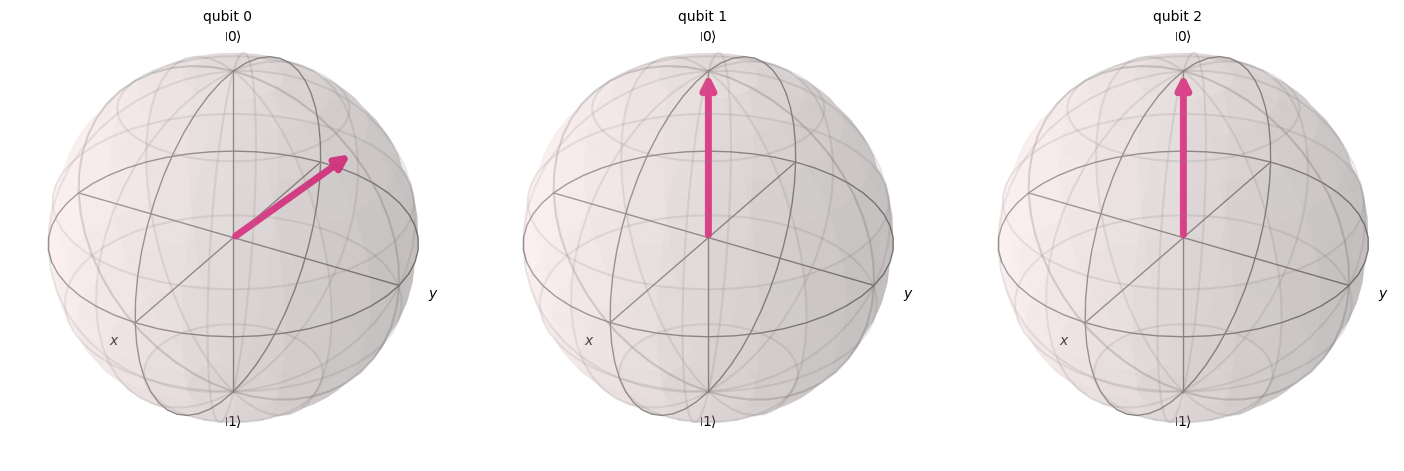

In [4]:
qc = QuantumCircuit(3)
theta, phi = np.pi/4, np.pi/2
qc.ry(theta, 0)
qc.rz(phi, 0)
# Save initial state for comparison
sv_initial = Statevector.from_instruction(qc)
print("Initial state of qubit 0:")
display(plot_bloch_multivector(sv_initial))
qc.h(1)
qc.cx(1, 2)
qc.cx(0, 1)
qc.h(0)

# Coherent corrections
qc.cx(1, 2)
qc.cz(0, 2)
qc.save_statevector()

In [5]:
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

# Retrieve the saved statevector
sv_final = result.data(0)["statevector"]
sv_final = Statevector(sv_final)

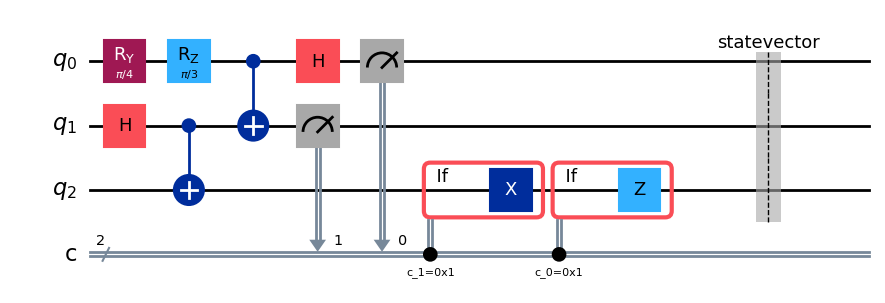

In [11]:
from qiskit.circuit import ClassicalRegister, QuantumRegister
from qiskit.circuit.controlflow import IfElseOp
qreg = QuantumRegister(3, 'q')
creg = ClassicalRegister(2, 'c')
qc_meas = QuantumCircuit(qreg, creg)
# Prepare arbitrary state |ψ⟩ on qubit 0
qc_meas.ry(np.pi/4, qreg[0])
qc_meas.rz(np.pi/3, qreg[0])
# Create entanglement between qubit 1 and 2
qc_meas.h(qreg[1])
qc_meas.cx(qreg[1], qreg[2])
# Bell measurement
qc_meas.cx(qreg[0], qreg[1])
qc_meas.h(qreg[0])
qc_meas.measure([qreg[0], qreg[1]], [creg[0], creg[1]])
with qc_meas.if_test((creg[1], 1)):
    qc_meas.x(qreg[2])

# If classical bit 0 == 1, apply Z on qubit 2
with qc_meas.if_test((creg[0], 1)):
    qc_meas.z(qreg[2])

# Save final statevector for analysis
qc_meas.save_statevector()
qc_meas.draw('mpl')


In [21]:
def teleport_fidelity(theta, phi):
    from qiskit import QuantumCircuit, transpile
    from qiskit.circuit import ClassicalRegister, QuantumRegister
    from qiskit.circuit.controlflow import IfElseOp
    from qiskit.quantum_info import Statevector, partial_trace
    import numpy as np

    # Create registers
    qreg = QuantumRegister(3, "q")
    creg = ClassicalRegister(2, "c")
    qc = QuantumCircuit(qreg, creg)

    # --- State preparation ---
    qc.ry(theta, qreg[0])
    qc.rz(phi, qreg[0])

    # --- Entanglement creation ---
    qc.h(qreg[1])
    qc.cx(qreg[1], qreg[2])

    # --- Bell measurement ---
    qc.cx(qreg[0], qreg[1])
    qc.h(qreg[0])
    qc.measure([qreg[0], qreg[1]], [creg[0], creg[1]])

    # --- Conditional corrections (modern syntax) ---
    with qc.if_test((creg[1], 1)):
        qc.x(qreg[2])
    with qc.if_test((creg[0], 1)):
        qc.z(qreg[2])

    qc.save_statevector()

    # --- Simulation ---
    compiled = transpile(qc, sim)
    result = sim.run(compiled).result()
    sv_final = Statevector(result.data(0)["statevector"])

    # --- Extract Bob’s qubit state ---
    rho_bob = partial_trace(sv_final, [0, 1])
    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]

    qc_init = QuantumCircuit(1)
    qc_init.ry(theta, 0)
    qc_init.rz(phi, 0)
    init_state = Statevector.from_instruction(qc_init)


    fidelity = np.abs(np.vdot(init_state.data, bob_state)) ** 2
    return fidelity


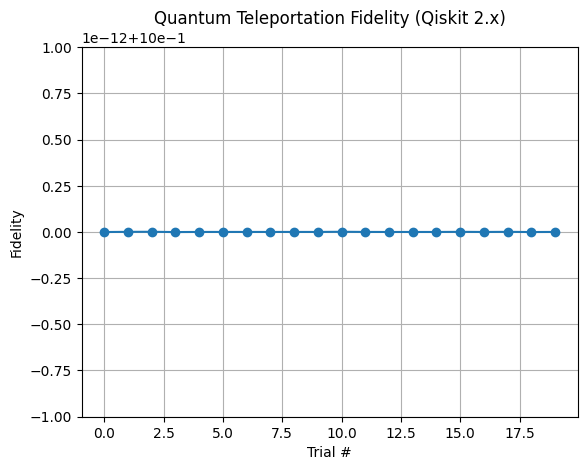

Average Fidelity: 1.0


In [22]:
fidelities = []
for _ in range(20):
    theta = np.random.uniform(0, np.pi)
    phi = np.random.uniform(0, 2*np.pi)
    fidelities.append(teleport_fidelity(theta, phi))

plt.plot(fidelities, marker='o')
plt.xlabel("Trial #")
plt.ylabel("Fidelity")
plt.title("Quantum Teleportation Fidelity (Qiskit 2.x)")
plt.grid(True)
plt.show()

print("Average Fidelity:", np.mean(fidelities))


In [27]:
from qiskit.visualization import plot_bloch_multivector
from qiskit.quantum_info import Statevector
import matplotlib.pyplot as plt

def show_state(qc, title=""):
    """Display the Bloch sphere for the current statevector."""
    state = Statevector.from_instruction(qc)
    fig = plot_bloch_multivector(state)
    plt.title(title)
    plt.show()



In [29]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

# Create a noise model
noise_model = NoiseModel()

# Define separate errors
error_1 = depolarizing_error(0.05, 1)   # 1-qubit gates
error_2 = depolarizing_error(0.05, 2)   # 2-qubit gates

# Apply them correctly
noise_model.add_all_qubit_quantum_error(error_1, ['h', 'rz', 'ry'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])


In [32]:
from qiskit_aer import AerSimulator
noisy_sim = AerSimulator(noise_model=noise_model)
